## Machine Learning for Computer Vision SoSe 2022

### Praktikum 4

Content Based Image Retrieval mit primitiven Merkmalen

Bauen Sie ein einfaches System zur inhaltsbasierten Bildsuche, basierend auf Farbmerkmalen. Verwenden
Sie dazu die in FELIX bereitgestellte Mini-Bilddatenbank wangCustom10 (1000 Bilder). Sie können das System später ggf. auf Ihre
eigenen Bildsammlungen anwenden. 

In [1]:
from skimage import io
from skimage.color import rgb2hsv
import numpy as np
import matplotlib.pyplot as plt


Entpacken Sie die bereitgestellte Bildersammlung in einen Ordner relativ zu diesem Notebook, so dass Sie im weitern Verlauf der Übung auf die Bilder zum Anzeigen und zum Berechnen von Merkmalen zugreifen können.

Um später einfach auf die Files im Verzeichnis zugreifen zu können, wird im folgenden eine Funktion bereitgestellt, die die Liste der Bilder aus einer Text-Datei ausliest, ggf. mit einem (relativen) Pfad ergänzt und die Liste der Bilder zurückgibt. 


In [2]:
# read the names of the images for the image DB
def getFileList(file_name, prefix):
    f = open(prefix + "/" + file_name, "r")
    imgNameList = []
    for line in f:
        # open image file
        imgNameList.append(prefix + line.rstrip())
    f.close()
    return imgNameList


import os


def getFilesInFolder(folderName):
    imgList = []
    for root, directories, files in os.walk(folderName, topdown=False):
        for name in files:
            eachFilePath = os.path.join(root, name)
            if "readme" not in eachFilePath:
                imgList.append(eachFilePath)
    return imgList


getFilesInFolder("wangCustom10/")


['wangCustom10/alaska\\114000.jpg',
 'wangCustom10/alaska\\114001.jpg',
 'wangCustom10/alaska\\114002.jpg',
 'wangCustom10/alaska\\114003.jpg',
 'wangCustom10/alaska\\114004.jpg',
 'wangCustom10/alaska\\114005.jpg',
 'wangCustom10/alaska\\114006.jpg',
 'wangCustom10/alaska\\114007.jpg',
 'wangCustom10/alaska\\114008.jpg',
 'wangCustom10/alaska\\114009.jpg',
 'wangCustom10/alaska\\114010.jpg',
 'wangCustom10/alaska\\114011.jpg',
 'wangCustom10/alaska\\114012.jpg',
 'wangCustom10/alaska\\114013.jpg',
 'wangCustom10/alaska\\114014.jpg',
 'wangCustom10/alaska\\114015.jpg',
 'wangCustom10/alaska\\114016.jpg',
 'wangCustom10/alaska\\114017.jpg',
 'wangCustom10/alaska\\114018.jpg',
 'wangCustom10/alaska\\114019.jpg',
 'wangCustom10/alaska\\114020.jpg',
 'wangCustom10/alaska\\114021.jpg',
 'wangCustom10/alaska\\114022.jpg',
 'wangCustom10/alaska\\114023.jpg',
 'wangCustom10/alaska\\114024.jpg',
 'wangCustom10/alaska\\114025.jpg',
 'wangCustom10/alaska\\114026.jpg',
 'wangCustom10/alaska\\11402

#### Erstellung von HSV-Farbhistogrammen
Schreiben Sie eine Funktion, die von einem Bild ein globales HSV-Farbhistogramm als Merkmal berechnet. Als Eingabeparameter soll dabei der Dateiname dienen. Als Rückgabewert soll die Funktion einen
numpy-Vektor erzeugen. Wählen Sie eine geeignete Quantisierung für das Histogramm.

http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2hsv

https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogramdd.html


(45,)


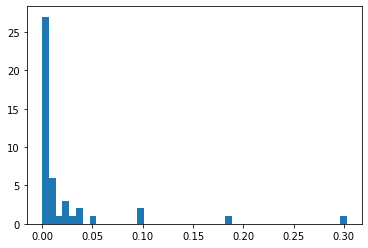

In [3]:
# Generated 3 * 5 * 5 = 45 bins

def hsvHistogramForRgbImage(imageFileName):
    img = io.imread(imageFileName)
    hsv_img = rgb2hsv(img).reshape(-1, 3)
    hist, edges = np.histogramdd(hsv_img, bins=(5, 3, 3))
    hist = hist.flatten()
    hist = hist / sum(hist)
    return hist

histogram_data = hsvHistogramForRgbImage("wangCustom10/mushroom/208009.jpg")

print(histogram_data.shape)
plt.hist(histogram_data, bins=45)
plt.show()


#### Histogramm Intersection zur Ähnlichkeitsbestimmung
Implementieren Sie eine Funktion, die zwei Merkmalsvektoren entgegennimmt und als Ähnlichkeitsmaß
den Histogram-Intersection Wert zurückgibt.

In [4]:
# https://stackoverflow.com/questions/52184242/numpy-calculate-histogram-intersection
def histogram_intersection(h1, h2):
    sm = 0
    # Use 45 bins here also
    for i in range(45):
        sm += min(h1[i], h2[i])
    return sm


histogram_compare_data_1 = hsvHistogramForRgbImage("wangCustom10/mushroom/208009.jpg")
histogram_compare_data_2 = hsvHistogramForRgbImage("wangCustom10/mushroom/208010.jpg")

print("Similar: " + str(histogram_intersection(histogram_compare_data_1, histogram_compare_data_2)))

histogram_compare_data_3 = hsvHistogramForRgbImage("wangCustom10/mushroom/208010.jpg")
histogram_compare_data_4 = hsvHistogramForRgbImage("wangCustom10/mushroom/208010.jpg")

print("The same: " + str(histogram_intersection(histogram_compare_data_3, histogram_compare_data_4)))

Similar: 0.527984619140625
The same: 0.9999999999999999


#### Erstellung Featuredatenbank
Erstellen Sie nun ein Skript, das HSV-Farbhistogramme für alle Bilder einer (kleinen) Bilddatenbank
vorberechnet und abspeichert. Sie können dabei die Liste mit den Bildnamen von oben verwenden. Achten Sie darauf, dass Sie die Merkmalsvektoren noch den Bildnamen zuordnen können (für ein Späteres Anzeigen der Bilder).

In [5]:

images_db = {}

for eachImage in getFilesInFolder("wangCustom10/"):
    images_db[eachImage] = hsvHistogramForRgbImage(eachImage)

#### Ähnlichste Bilder bestimmen
Erstellen Sie eine Funktion, die für ein Anfragebild die Ähnlickeiten zu allen Bildern in der DB berechnet
(mit Hilfe der Histogram Intersection). Die Ähnlichkeiten sollen als 1D np-Array zurückgegeben werden.

In [6]:
def getSimilarityToImageWithPath(imagePath):
    similarityArray = []

    histogramToCompareTo = images_db[imagePath]

    for key, value in images_db.items():
        if imagePath not in key:
            similarityArray.append(histogram_intersection(histogramToCompareTo, value));
    return similarityArray;

def getSimilarityToImageWithPathAsDictionary(imagePath):
    similarityDictionary = {}

    histogramToCompareTo = images_db[imagePath]

    for key, value in images_db.items():
        if imagePath not in key:
            similarityDictionary[key] = histogram_intersection(histogramToCompareTo, value);
    return similarityDictionary;


#print(getSimilarityToImageWithPath("wangCustom10/alaska\\114000.jpg"));


#### Visualisierung Ergebnisse
Suchen Sie nun ein Anfragebild aus (kann in der vorgegebenen Sammlung enthalten sein). Zu diesem Anfragebild sollen nun die 10 ähnlichsten Bilder (bzüglich den oben erstellten Merkmalen und HI) gefunden werden.

Geben Sie die 10 ähnlichsten Bilder in einer übersichtlichen Darstellung aus. Ergänzen Sie die Darstellung der Bilder mit dem jeweiligen Ähnlichkeitswert. 


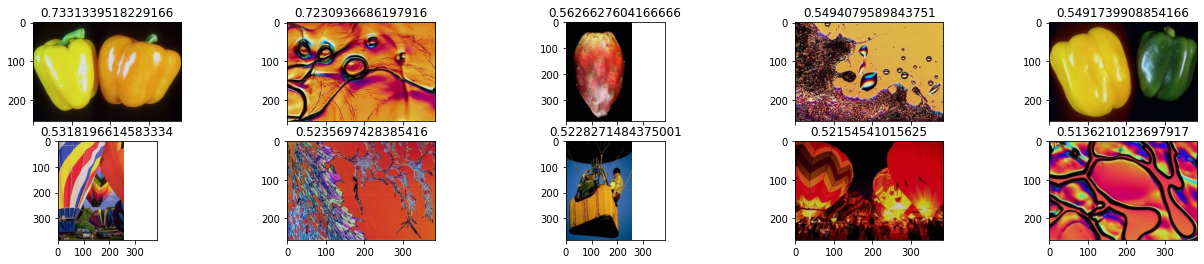

In [9]:
import operator


def getFirstTenSimilarImages(filePath):
    similaritiesDictionary = getSimilarityToImageWithPathAsDictionary(filePath)
    sorted_tuples = sorted(
        similaritiesDictionary.items(), key=operator.itemgetter(1), reverse=True
    )
    sortedSimilaritiesDictionary = {k: v for k, v in sorted_tuples}

    firstTenImages = list(sortedSimilaritiesDictionary.items())[:10]
    return firstTenImages


def showTenImagesGridWithSimilarityScore(imageDictionary):
    f, axarr = plt.subplots(2, 5, sharex=True)

    flatAxarr = axarr.flatten()

    # f.set_figheight(15)
    f.set_figwidth(22)

    for eachImageIndex, eachImage in enumerate(imageDictionary):
        flatAxarr[eachImageIndex].imshow(io.imread(eachImage[0]))
        flatAxarr[eachImageIndex].set_title(str(eachImage[1]))


showTenImagesGridWithSimilarityScore(
    getFirstTenSimilarImages("wangCustom10/vegtable\\169041.jpg")
)


Um das spätere Experimentieren zu erleichtern können Sie die berechneten Merkmale in einer Datei persistieren, um später nicht mehr alles neu berechnen zu müssen. Dann können Sie bei Bedarf einfach die Merkmale aus der Datei laden.

https://scikit-learn.org/stable/modules/model_persistence.html

In [10]:
import pickle
from joblib import dump, load

with open("images_hist_db.pkl", "wb") as f:
    pickle.dump(images_db, f)


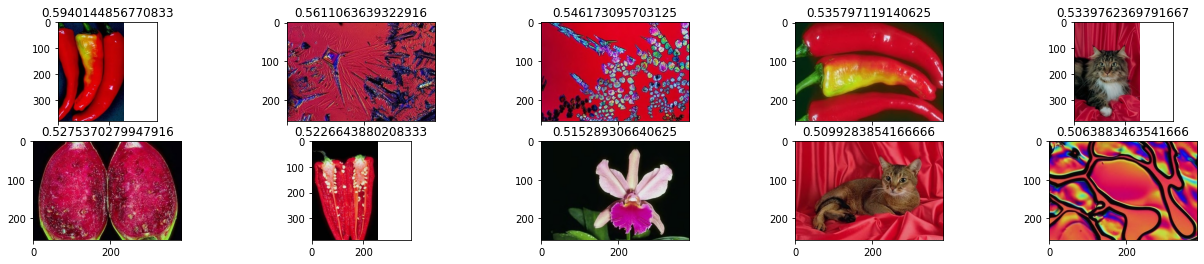

In [12]:
with open("images_hist_db.pkl", "rb") as f:
    images_db = pickle.load(f)

showTenImagesGridWithSimilarityScore(
    getFirstTenSimilarImages("wangCustom10/vegtable\\169004.jpg")
)

Experimentieren Sie! Wann funktioniert die Bildsuche mit Farbhistogrammen gut, wann nicht?